## Influenza in Australia 

### Introduction 

_"Gather insights from the provided dataset and develop a simple predictive model to forecast the volume of flu cases."_


__This notebook aims to benchmark vanilla models against a forecasting task.__ The data is influenza case counts in Australia over a period of roughly 9 years (data source:  http://www9.health.gov.au/cda/source/pub_influ.cfm). An introduction to the fields of the data will not be necessary as the solution's will have a sequential approach. The models to be benchmarked are:

	- Seasonal Random Walk
	- Seasonal Autoregressive Integrated Moving Average (SARIMA)
	- Recurrent Network
    
#### Table of Contents:

	1) Data Curation 
	2) Sequence Building and Resampling
	3) Model Parameter Selection for SARIMA
	4) Parameter Testing for SARIMA
	5) Sequence Building for RNN
	6) Parameter Testing for RNN
	7) Benchmarking
    
    
## 1) Data Curation 

Importing necessary packages for python and setting visualisation backends.

In [96]:
import pandas as pd
import statsmodels.api as sm  
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


%matplotlib inline
sns.set()

Importing data. It is useful to point out that the original data was in XML format. I got rid of the formatting in Microsoft Excel and exported the raw data to a CSV format to ease the process in Pandas.

Next, the naming and typing conventions are dealt with. Turning the features to strings and dates to np.datetime64 objects. In addition to these conventions, a single field is created encoding the year the record was recorded. Although could be parsed later from the datetime object, I do this for convenience as the dataset is small with no memory problems.   

In [97]:
# import
influenza = pd.read_csv('influenza.csv')

# consistent naming convention
influenza.columns = ['week', 'state', 'age', 'sex', 'indigenous', 'type'] 

# typing 
influenza.week = pd.to_datetime(influenza.week)
influenza.state = influenza.state.astype('str')
influenza.age = influenza.age.astype('str')
influenza.sex = influenza.sex.astype('str')
influenza.indigenous = influenza.indigenous.astype('str')
influenza.type = influenza.type.astype('str')

# adding year column
influenza['year'] = [i.year for i in influenza.week]

During my exploration of the data in Tableau, I see that there are vast differences in collected data over the years. This _could_ be due to the number of cases (maybe people just got really sick that year..), however, this could also be a data quality issue. This is a risk not worth taking. It is useful to look at the gaps in the data.  

Text(0, 0.5, '')

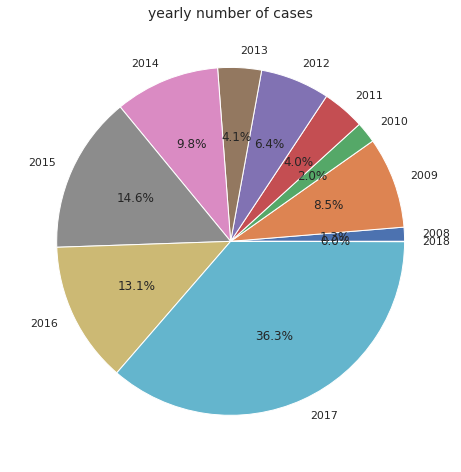

In [98]:
plt.figure(figsize=(20,8))
influenza.groupby('year').count()['week'].plot.pie(autopct="%.1f%%")
plt.title("yearly number of cases", fontsize=14)
plt.ylabel("")

The majority (86.2 %) of the cases recorded is from 2010-2017 and we have some missing data points, the absence of the data points _could_ be due to zero cases recorded at the time for the territories however I will still take action on them.  

#### Actions:

- not taking 2018 - incomplete data for 2018 (keeping it clean, not using it, it is just one wk of data)
- not taking 2009 - in order to not introduce drift for, H1N1 pandemic of 2009 (the spike you see at 8.5% in 2009)
- not taking 2008 - 2009 not being in the modeling, going to not use 2008 as well. Do not want to patch for a year
- Prior to 2014, there seems to be missing data for some states compared to after 2014.. will need to patch

now will need to do some patching of the missing sequences in some states.

In [99]:
# as we are dealing with sequential data, it is important to chech for data quality. 
# is the sequence consistent for each year & each state? 

for year in influenza.year.unique():
    for state in influenza.state.unique():
        recorded_wks = len(influenza[(influenza.year == year) & (influenza.state == state)].week.unique())
        if recorded_wks < 50:
            print ("{} weeks are missing in {} - {}".format(52 - recorded_wks, state , year)) 

51 weeks are missing in NSW - 2018
51 weeks are missing in NT - 2018
51 weeks are missing in Qld - 2018
51 weeks are missing in SA - 2018
51 weeks are missing in Vic - 2018
51 weeks are missing in WA - 2018
51 weeks are missing in Tas - 2018
4 weeks are missing in Tas - 2015
13 weeks are missing in Tas - 2013
5 weeks are missing in NT - 2012
7 weeks are missing in Tas - 2012
4 weeks are missing in NT - 2011
8 weeks are missing in Tas - 2011
15 weeks are missing in NT - 2010
17 weeks are missing in Tas - 2010
9 weeks are missing in NT - 2009
6 weeks are missing in SA - 2009
3 weeks are missing in Vic - 2009
21 weeks are missing in Tas - 2009
12 weeks are missing in NT - 2008
20 weeks are missing in SA - 2008
17 weeks are missing in Tas - 2008


In [100]:
# taking the subset we will be dealing with

influenza_subset = influenza[influenza.year.isin(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])]


NSW = influenza_subset[influenza_subset.state == 'NSW'].reset_index(drop='index')
NT = influenza_subset[influenza_subset.state == 'NT'].reset_index(drop='index')
QLD = influenza_subset[influenza_subset.state == 'Qld'].reset_index(drop='index')
SA = influenza_subset[influenza_subset.state == 'SA'].reset_index(drop='index')
TAS = influenza_subset[influenza_subset.state == 'Tas'].reset_index(drop='index')
VIC = influenza_subset[influenza_subset.state == 'Vic'].reset_index(drop='index')
WA = influenza_subset[influenza_subset.state == 'WA'].reset_index(drop='index')


# checking how many weeks each state has generated reports

print('NSW has {} records between 2010 & 2017'.format(len(NSW.sort_values('week').week.unique())))
print('NT has {} records between 2010 & 2017'.format(len(NT.sort_values('week').week.unique())))
print('QLD has {} records between 2010 & 2017'.format(len(QLD.sort_values('week').week.unique())))
print('SA has {} records between 2010 & 2017'.format(len(SA.sort_values('week').week.unique())))
print('TAS has {} records between 2010 & 2017'.format(len(TAS.sort_values('week').week.unique())))
print('VIC has {} records between 2010 & 2017'.format(len(VIC.sort_values('week').week.unique())))
print('WA has {} records between 2010 & 2017'.format(len(WA.sort_values('week').week.unique())))

NSW has 418 records between 2010 & 2017
NT has 387 records between 2010 & 2017
QLD has 418 records between 2010 & 2017
SA has 416 records between 2010 & 2017
TAS has 367 records between 2010 & 2017
VIC has 418 records between 2010 & 2017
WA has 417 records between 2010 & 2017


## 2) Sequence Building and Resampling

NSW, QLD, & VIC generated the most & the same number of reports between 2010 & 2017. Before taking their timestamps as a skeleton for our time-series, we should check if these states' timelines are aligned.

In [101]:
match_set = [set(NSW.sort_values('week').week.unique() == state.sort_values('week').week.unique()) for state in [QLD,VIC]]
if match_set == [{True}, {True}]:
    print('All timestamps are in alignment')

All timestamps are in alignment


As the timestamps are in alignment we can go ahead and take the timestamps as a basis to build our series. For this, we create a mapping just to keep everything in order. 

- 0 -> date 1
- 1 -> date 2
- 2 -> date 3 ...

In [102]:
# taking NSW timestamps as base for sequence and building a dictionary for it: 

sequence = dict(zip(pd.to_datetime(NSW.sort_values('week').week.unique()), range(len(NSW.sort_values('week').week.unique()))))

# inverse mapping - maybe useful

inv_map_sequence = {v: k for k, v in sequence.items()}

Now we have clear definitions of our sequences. 

#### Action:

- Finding missing sequences in each state and patch them with linear interpolation

In [103]:
# adding sequence column to dataframes - to replace timestamps:

NSW['sequence'] = [sequence[i] for i in NSW.week]
NT['sequence'] = [sequence[i] for i in NT.week]
QLD['sequence'] = [sequence[i] for i in QLD.week]
SA['sequence'] = [sequence[i] for i in SA.week]
TAS['sequence'] = [sequence[i] for i in TAS.week]
VIC['sequence'] = [sequence[i] for i in VIC.week]
WA['sequence'] = [sequence[i] for i in WA.week]

In [104]:
# overwriting state dataframes with time-series of counts of events grouped by their sequences

NSW = NSW.groupby('sequence').count()['state'].reset_index()
NT = NT.groupby('sequence').count()['state'].reset_index()
QLD = QLD.groupby('sequence').count()['state'].reset_index()
SA = SA.groupby('sequence').count()['state'].reset_index()
TAS = TAS.groupby('sequence').count()['state'].reset_index()
VIC = VIC.groupby('sequence').count()['state'].reset_index()
WA = WA.groupby('sequence').count()['state'].reset_index()

NSW.columns = ['sequence', 'nsw_case_count']
NT.columns = ['sequence', 'nt_case_count']
QLD.columns = ['sequence', 'qld_case_count']
SA.columns = ['sequence', 'sa_case_count']
TAS.columns = ['sequence', 'tas_case_count']
VIC.columns = ['sequence', 'vic_case_count']
WA.columns = ['sequence', 'wa_case_count']

NSW['date'] = [inv_map_sequence[i] for i in NSW.sequence]
NT['date'] = [inv_map_sequence[i] for i in NT.sequence]
QLD['date'] = [inv_map_sequence[i] for i in QLD.sequence]
SA['date'] = [inv_map_sequence[i] for i in SA.sequence]
TAS['date'] = [inv_map_sequence[i] for i in TAS.sequence]
VIC['date'] = [inv_map_sequence[i] for i in VIC.sequence]
WA['date'] = [inv_map_sequence[i] for i in WA.sequence]

In [105]:
# as we took NSW - QLD & VIC's time line for skeleton, 
# we concat their sequence columns to the rest to see the gaps in other states. Taking NSW

# NSW stays the same
# NT 
NT = pd.merge(NSW, NT, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
NT.columns = ['sequence', 'date', 'case_count']
# QLD (don't really need to do it, as has same sequence count already as NSW but doing it anyway - paranoid :D)
QLD = pd.merge(NSW, QLD, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
QLD.columns = ['sequence', 'date', 'case_count']
# SA 
SA = pd.merge(NSW, SA, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
SA.columns = ['sequence', 'date', 'case_count']
# TAS
TAS = pd.merge(NSW, TAS, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
TAS.columns = ['sequence', 'date', 'case_count']
# VIC (don't need to do it but doing it anyway .. )
VIC = pd.merge(NSW, VIC, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
VIC.columns = ['sequence', 'date', 'case_count']
# WA
WA = pd.merge(NSW, WA, on='sequence', how='outer').drop(['nsw_case_count', 'date_y'], axis=1)
WA.columns = ['sequence', 'date', 'case_count']
# change NSW column names for consistent naming
NSW.columns = ['sequence', 'case_count', 'date']


In [106]:
# now we have set up everything for a clear linear interpolation 
# vanilla interpolate does it in a linear fashion. It is an 'in-between' method. So edges wouldn't be filled
# TAS has edge values missing (ex: the very first part of the sequence 0, this can't be filled in like that)
# for this reason we can use .bfill().ffill() methods sequentially in order to fill in the nearest value 
# for these edge cases

NSW = NSW.interpolate().bfill().ffill()
NT = NT.interpolate().bfill().ffill()
QLD = QLD.interpolate().bfill().ffill()
SA = SA.interpolate().bfill().ffill()
TAS = TAS.interpolate().bfill().ffill()
VIC = VIC.interpolate().bfill().ffill()
WA = WA.interpolate().bfill().ffill()

# turn case counts back to int type after interpolation


NSW.case_count = NSW.case_count.astype(int)
NT.case_count = NT.case_count.astype(int)
QLD.case_count = QLD.case_count.astype(int)
SA.case_count = SA.case_count.astype(int)
TAS.case_count = TAS.case_count.astype(int)
VIC.case_count = VIC.case_count.astype(int)
WA.case_count = WA.case_count.astype(int)

##### Time-Series plots for each state

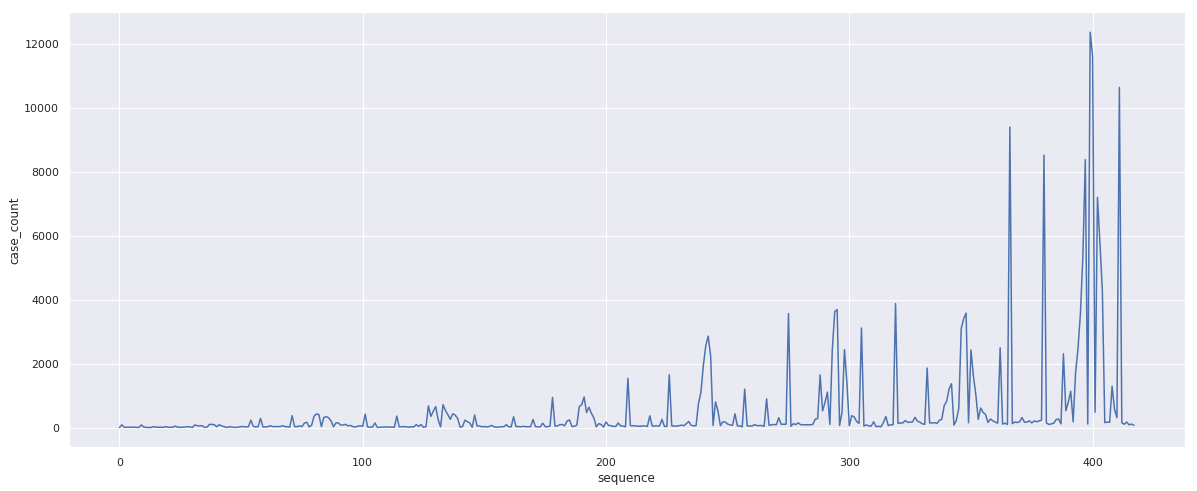

In [107]:
plt.figure(figsize=(20,8))
sns.lineplot(data=NSW, x="sequence", y="case_count")

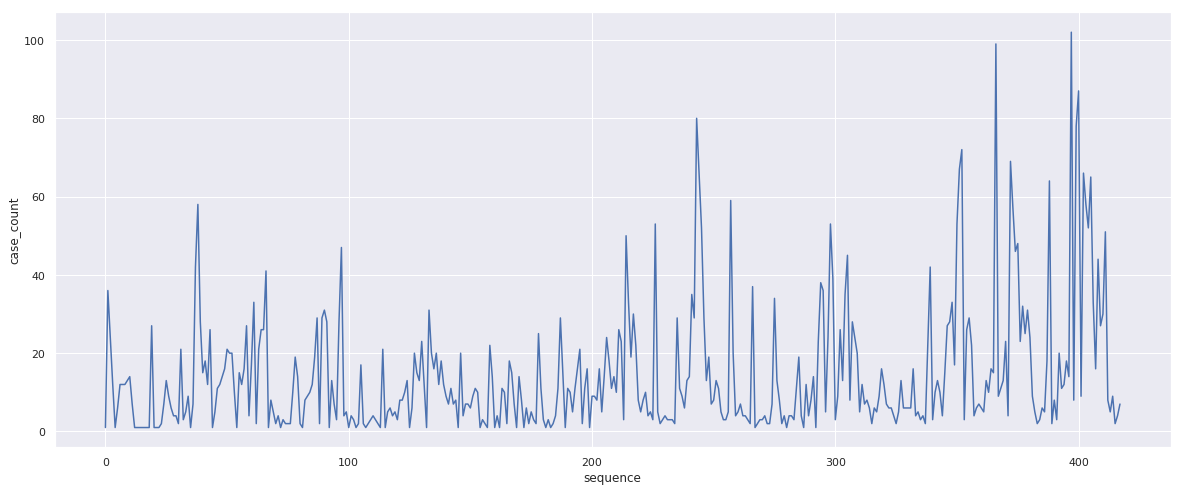

In [108]:
plt.figure(figsize=(20,8))
sns.lineplot(data=NT, x="sequence", y="case_count")

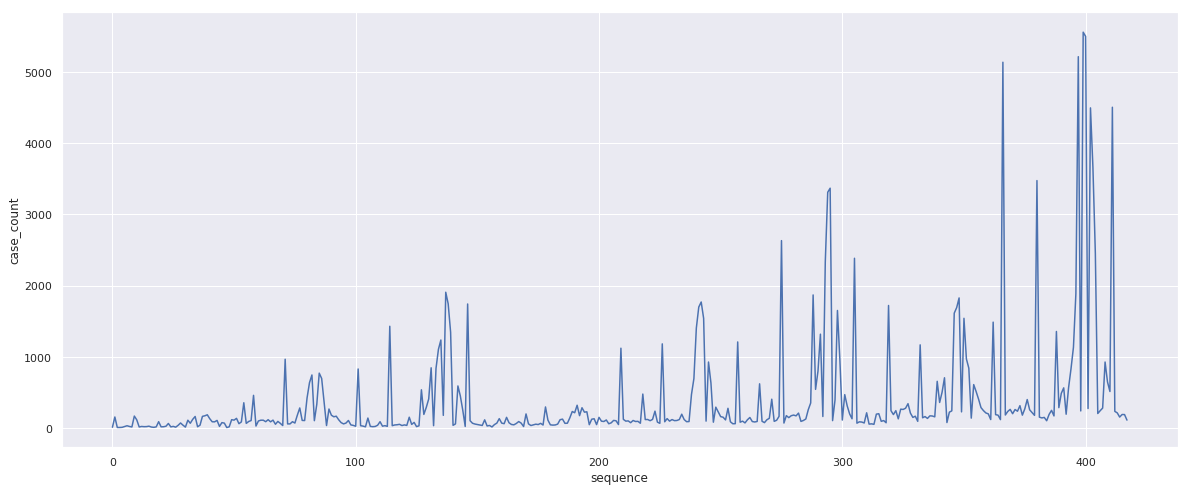

In [109]:
plt.figure(figsize=(20,8))
sns.lineplot(data=QLD, x="sequence", y="case_count")

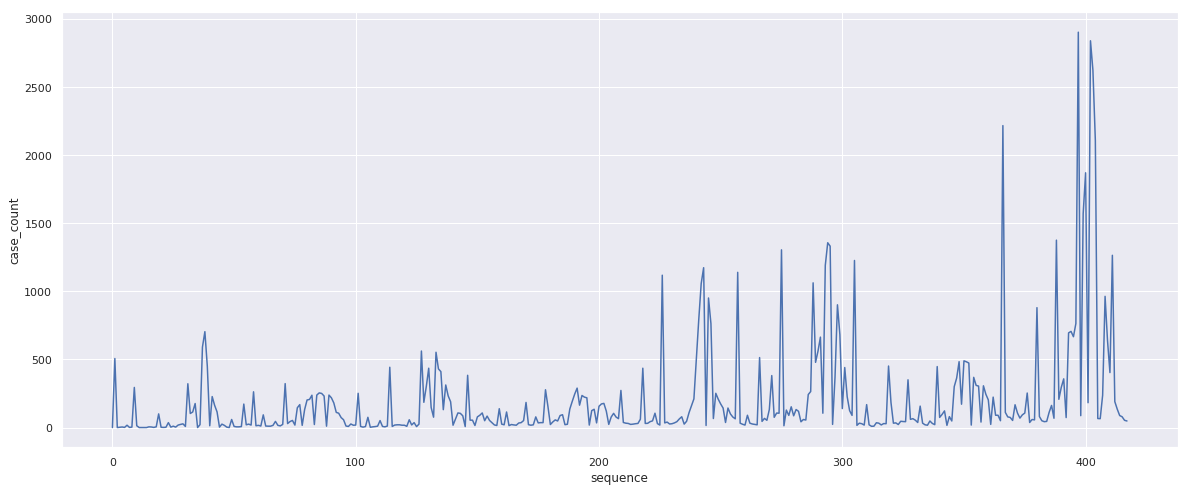

In [110]:
plt.figure(figsize=(20,8))
sns.lineplot(data=SA, x="sequence", y="case_count")

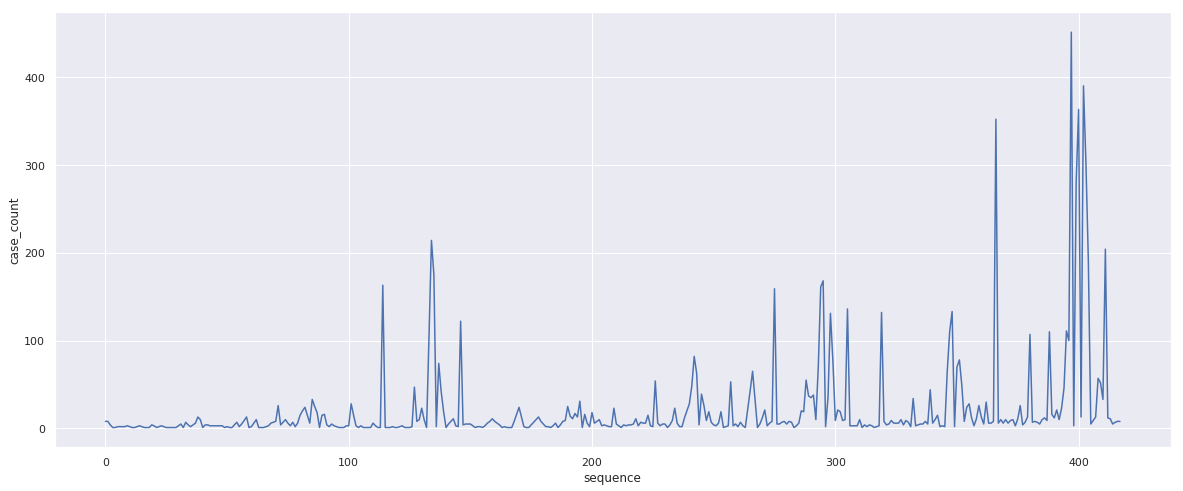

In [111]:
plt.figure(figsize=(20,8))
sns.lineplot(data=TAS, x="sequence", y="case_count")

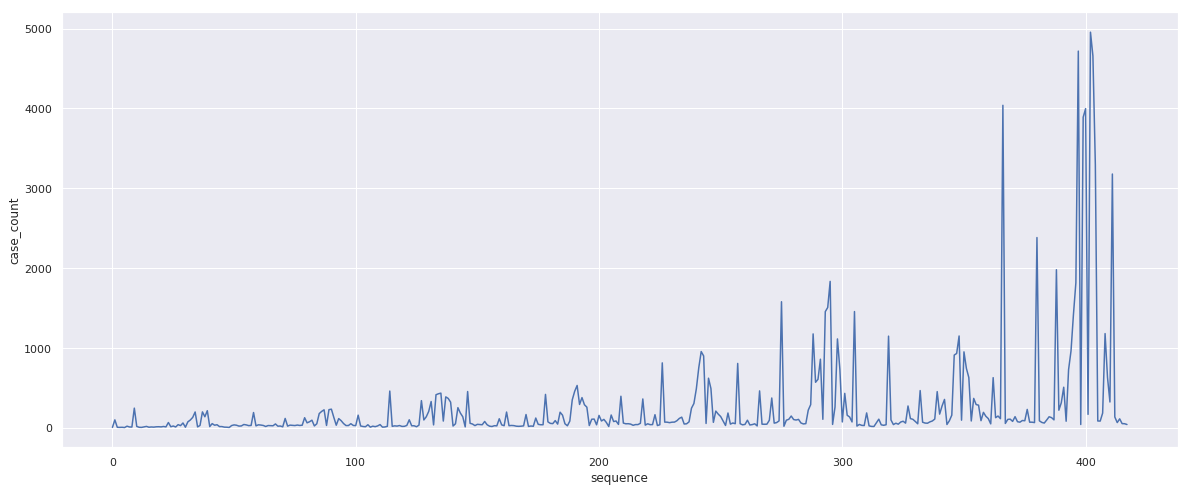

In [112]:
plt.figure(figsize=(20,8))
sns.lineplot(data=VIC, x="sequence", y="case_count")

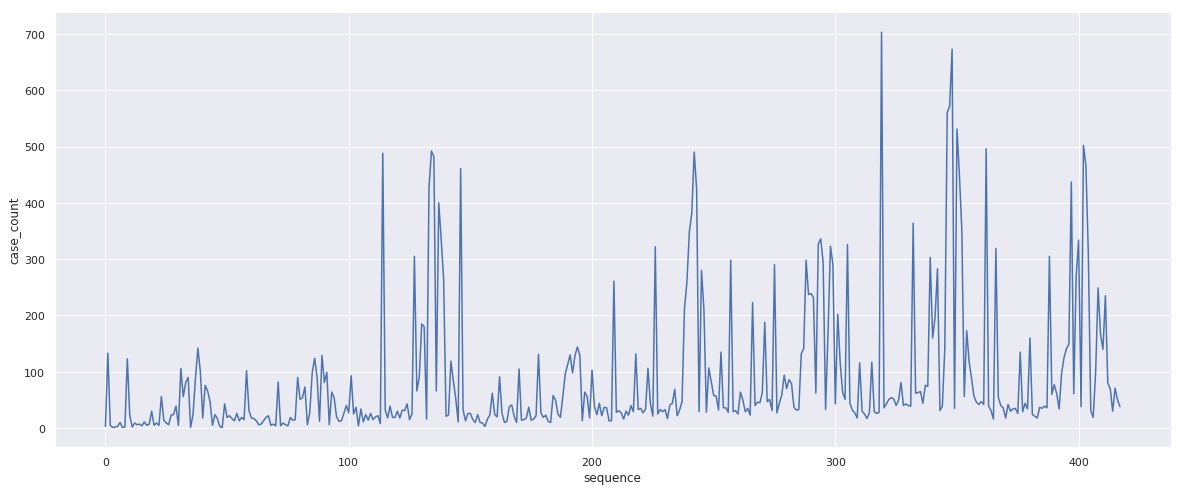

In [113]:
plt.figure(figsize=(20,8))
sns.lineplot(data=WA, x="sequence", y="case_count")

There seems to be the same seasonality for each state. So we can add the signals together. This also makes things more simple. We combine the signals to create a complete **national influenza time-series** 

To create further consistency in the signal and since the task asks to forecast '6 months ahead', I resample the time series in an additive fashion to end up with a monthly time-series.  There are some technical semantics with building this in Pandas, the below cell takes care of the series.

In [115]:
%%capture
AU = pd.concat([NSW, QLD, VIC, SA, NT, TAS, WA]).groupby('date').sum()
AU_seq = AU.reset_index()
AU_date = AU.index
AU_case = AU.case_count
AU = pd.Series(data = AU_case, index = AU_date)
AU.sort_index(inplace=True)
# getting dates for closest sunday so series object can have a frequency attribute
# first resampling it by week to get alignment on dates - cheking if we can.
AU_influenza = AU.resample("W").sum()
##################################################################################
# final Australia dataframe with Weekly-frq
date = AU_influenza.index
AU_influenza = pd.Series(data = list(AU_case), index = date)
# monthly resample to complete the job.
AU_influenza = AU_influenza.resample("M").sum()

Below is a very basic seasonal decomposition. The data is fairly straight forward to decompose (especially after the resampling). This decomposition separates the seasonality and the trend from our original signal.

#### Observations:

There is clear seasonality  
The trend(!) is upward in recent years (very reluctant to call it a trend)

<Figure size 432x288 with 0 Axes>

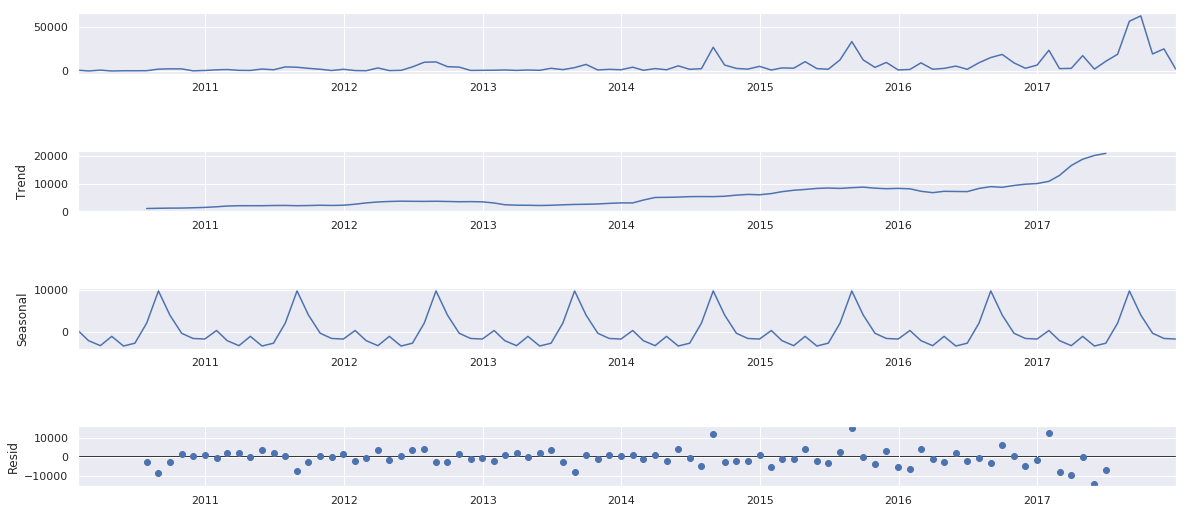

In [24]:
decomposition = seasonal_decompose(AU_influenza)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 8)

## 3) Model Parameter Selection for SARIMA

Although clearly see the trend rise over time we would still want to test stationariness with the Dickey-Fuller test.

Ho = 'Time Series is Non-Stationary'

In [116]:
def test_stationary(df): 
    print('DF Statistic: {}'.format(adfuller(df)[0]))
    print('DF crit value: {}'.format(adfuller(df)[4]['1%']))
    print('DF crit value: {}'.format(adfuller(df)[4]['5%']))
    print('DF crit value: {}'.format(adfuller(df)[4]['10%']))

In [117]:
test_stationary(AU_influenza)

DF Statistic: 1.486989613442251
DF crit value: -3.510711795769895
DF crit value: -2.8966159448223734
DF crit value: -2.5854823866213152


Although the DF value is much larger then the 5% crit value, cannot reject the null hypothesis. We try to make the series stationary for an autocorrelation plot.  

In [118]:
station = pd.DataFrame(data = list(AU_influenza.values), index=AU_influenza.index, columns=['x'])

In [119]:
station['first_difference'] = station.x - station.x.shift(1)  

In [120]:
test_stationary(station.first_difference.dropna())

DF Statistic: -6.749123454596909
DF crit value: -3.510711795769895
DF crit value: -2.8966159448223734
DF crit value: -2.5854823866213152


Take both seasonality and first difference

In [121]:
station['seasonal_first_difference'] = station.first_difference - station.first_difference.shift(12)  

In [122]:
test_stationary(station.seasonal_first_difference.dropna())

DF Statistic: -2.1136718643118506
DF crit value: -3.524624466842421
DF crit value: -2.9026070739026064
DF crit value: -2.5886785262345677


Stationary Signal

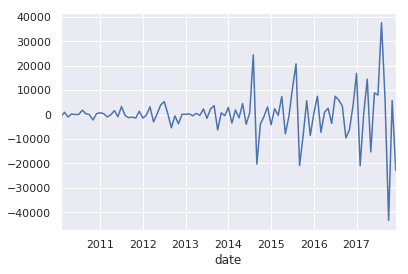

In [123]:
station.first_difference.dropna().plot()

- Autocorrelations have good number of positives in high lag and has a pattern so may need differencing. However, as mentioned, influenza 'trends' seem to rise one year and fall for the next few. It would be very bold to add and Integrated value into an ARIMA for a long term forecast for a signal like this. So will keep differencing at a zero.  
- The Partial Autocorrelation sees sharp cuts - should consider AR process (significant drops in lag 1 & 3)..
- As does PACF .. (1 & 3)

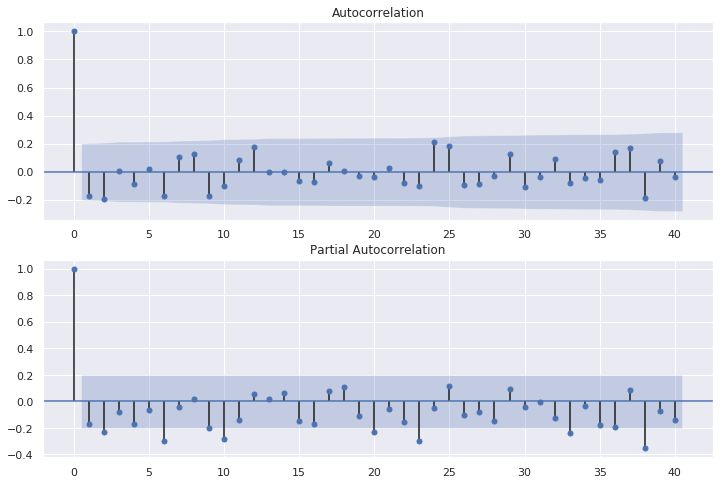

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(station.first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(station.first_difference.dropna(), lags=40, ax=ax2)

## 4) Parameter Testing for SARIMA

We split the series into train and test. We then fit the ARIMA with the parameter ranges we chose. Benchmark them against a MSE for the test series 

In [124]:
split = round((len(AU_influenza) * 70) / 100)
train = AU_influenza[0:split]
test = AU_influenza[split:]

In [125]:
%%capture
combo = []
mse = []
for p in (1,3):
    for q in (1,3):
            
        mod = sm.tsa.statespace.SARIMAX(train, trend='n', seasonal_order=(p,0,q,12), initialization='approximate_diffuse', enforce_stationarity=False)
        results = mod.fit()
        forecast = results.predict(start = split, end= len(AU_influenza) -1 , dynamic= True)  
        m = mean_squared_error(test, forecast)
        combo.append((p,0,q))
        mse.append(m)
            
results = pd.DataFrame(data=[combo,mse]).T
results.columns = ['arima', 'mse']

In [126]:
results.sort_values('mse')

,arima,mse
0,"(1, 0, 1)",9.60578e+07
2,"(3, 0, 1)",1.00742e+08
3,"(3, 0, 3)",1.27362e+08
1,"(1, 0, 3)",1.5303e+08


We see that (1,0,1,12) is best fit for our seasonal order and parameters
Further testing shows us that the general signal order is a best fit with (1,0,0). Very slightly improving over (0,0,0). 

__Therefore we take our SARIMA with parameters (1,0,0)(1,0,1,12)__

## 5) Sequence Building for RNN

## 6) Parameter Testing for RNN

## 7) Benchmarking

209519100.6551724

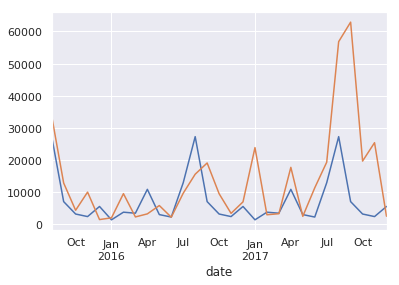

In [49]:
# SARIMA

mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1,0,0), seasonal_order=(1,0,1,12),initialization='approximate_diffuse', enforce_stationarity=False)
results = mod.fit()
forecast = results.predict(start = split, end= len(AU_influenza) -1 , dynamic= True)  
forecast.plot()
test.plot()
mean_squared_error(test,forecast)

# RW

mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(0,0,0), seasonal_order=(0,1,0,12),initialization='approximate_diffuse', enforce_stationarity=False)
results = mod.fit()
forecast = results.predict(start = split, end= len(AU_influenza) -1 , dynamic= True)  
forecast.plot()
test.plot()
mean_squared_error(test,forecast)